In [9]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

import sys
sys.path.insert(0, "../tfspline")

try:
    import model
    import plot
    import sampledata
    import parallel
except ImportError:
    print('No Import')

## Input data
To simplify choice of constants we shift and scale data such that values are in the [0, 1] range. Otherwise we would need to adapt learning rate and similar things. We skip the back-transformation as we would do in production code.

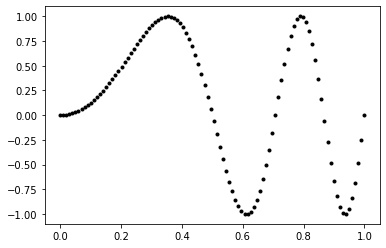

In [10]:
# Generate input data
#data_x = np.linspace(0, 0.5*np.pi, 20)
data_x = np.linspace(0, 1, 100)
#data_y = np.sin(data_x)
data_y = np.sin(data_x**2 * 4 * np.pi)
#[data_x, data_y] = sampledata.rescale_input_data(data_x, data_y)

plt.plot(data_x, data_y, 'k.')

## Spline properties based on Stefan Huber's findings in "Polynomial approximation.ipynb"

### Learning rate

0.1

### Gradient regularization

SGD benefits from regularization while adaptive optimizers (Adam) do not.
However, the regularization does not have any negative effect with adaptive optimizers, so we will leave it on in both cases.

### Input data

Number of points: Increasing the number of points to be approximated regulates the convergence. However, the effect is mild.
Noise / shape of input: Does not affect convergence.

### Optimizers

We limit ourselves to SGD and Adam, as other optimizers fail for high learning rate (0.1) in our application.
SGD: nesterov = true, momentum = 0.95
Adam: beta1 = 0.9

### Polynomial degree

With Adam and SGD after 500 epochs we see best results with polynomial degree 5.

### Number of polynomials
We start with observing the problem using only 2 polynomial pieces since we do not expect the behavior to be fundamentally different to using higher number of polynomial pieces.  
We will then use the findings of this smaller problem and apply them to larger number of segments.

In [11]:
learning_rate_adam = 0.1 
learning_rate_sgd = 0.1
gradient_regularization=True
deg=5
n=12
continuity=False
seg_overlap = 0
epochs=50000

## Investigating convergence with only approximation error in loss function with 8 polynomial segments

### Interpretation of results
Although AMSGrad is able to achieve a lower remaining error than SGD, its loss function still shows a declining tendency after 100000 (!) epochs.

In [12]:
spline_adam2 = model.Spline(polydegree=deg, polynum=n, ck=2)
spline_adam2.continuity = continuity

opt = keras.optimizers.Adam(learning_rate=learning_rate_adam, amsgrad=True)

spline_adam2.fit(data_x, data_y, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1,
factor_ck_pressure=0, factor_curvature=0, gradient_regularization=gradient_regularization, overlap_segments=seg_overlap)

spline_sgd2 = model.Spline(polydegree=deg, polynum=n, ck=2)
spline_sgd2.continuity = continuity

opt = keras.optimizers.SGD(learning_rate=learning_rate_sgd, momentum=0.95, nesterov=True)

spline_sgd2.fit(data_x, data_y, optimizer=opt, n_epochs=epochs, factor_approximation_quality=1,
factor_ck_pressure=0, factor_curvature=0, gradient_regularization=gradient_regularization, overlap_segments=seg_overlap)

TensorFlow: Number of recognized GPUs:  0
TensorFlow: Number of recognized GPUs:  0


<tf.Tensor: shape=(), dtype=float64, numpy=0.003795249189205281>

Text(0.5, 1.0, 'Total Loss')

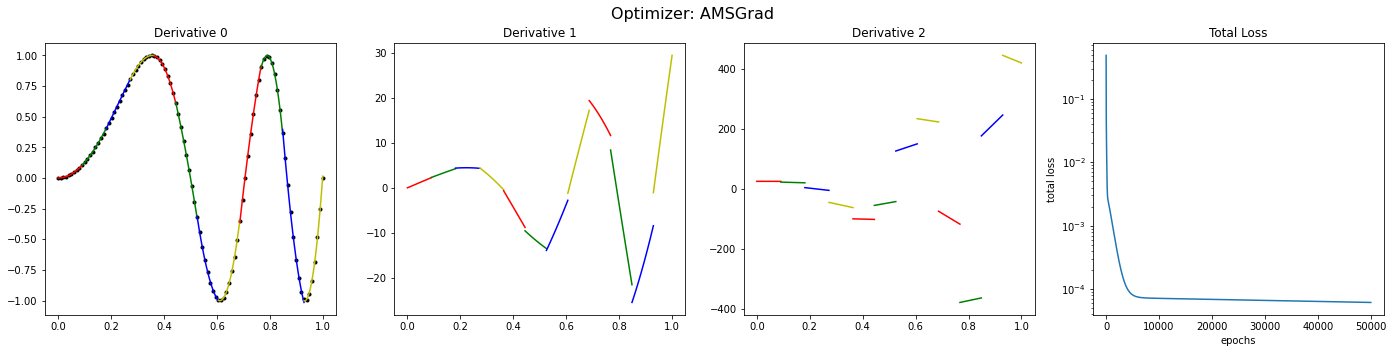

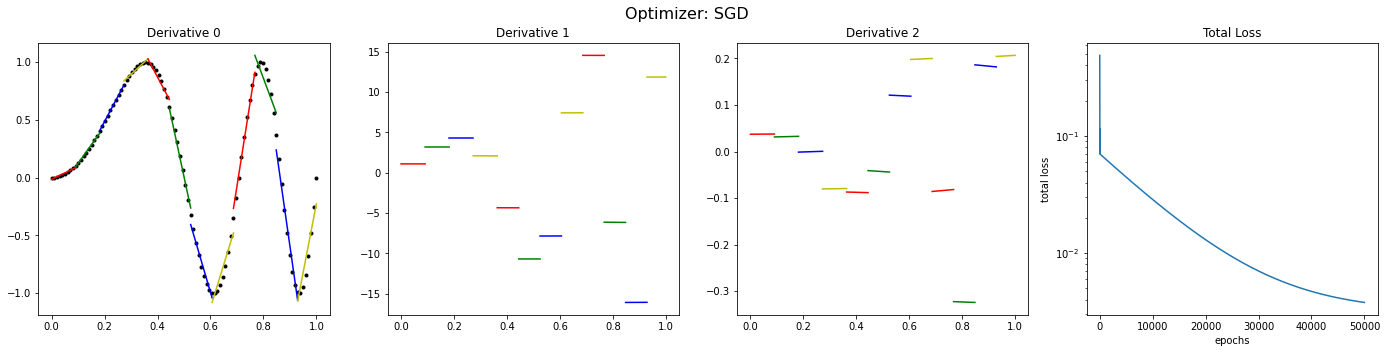

In [13]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(24)
fig.set_figheight(5)
ep = np.linspace(0, epochs, epochs)

fig.suptitle('Optimizer: AMSGrad', fontsize=16)
axes[0].plot(data_x, data_y, '.', color="black")
plot.plot_spline(spline_adam2, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0])
axes[0].set_title('Derivative 0')
plot.plot_spline(spline_adam2, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[1])
axes[1].set_title('Derivative 1')
plot.plot_spline(spline_adam2, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[2])
axes[2].set_title('Derivative 2')
plot.plot_loss(spline_adam2, type='total', ax=axes[3])
axes[3].set_title('Total Loss')

fig, axes = plt.subplots(1, 4)
fig.set_figwidth(24)
fig.set_figheight(5)
ep = np.linspace(0, epochs, epochs)

fig.suptitle('Optimizer: SGD', fontsize=16)
axes[0].plot(data_x, data_y, '.', color="black")
plot.plot_spline(spline_sgd2, plot_input=False, deriv=0, plot_max_h_lines=False, segment_resolution = 100, ax=axes[0])
axes[0].set_title('Derivative 0')
plot.plot_spline(spline_sgd2, plot_input=False, deriv=1, plot_max_h_lines=False, segment_resolution = 100, ax=axes[1])
axes[1].set_title('Derivative 1')
plot.plot_spline(spline_sgd2, plot_input=False, deriv=2, plot_max_h_lines=False, segment_resolution = 100, ax=axes[2])
axes[2].set_title('Derivative 2')
plot.plot_loss(spline_sgd2, type='total', ax=axes[3])
axes[3].set_title('Total Loss')